### Instalação de Dependências

In [9]:
!pip install mediapipe

### Importação de Bibliotecas

In [10]:
import os
import json
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

### Carregando e Explorando o Dataset

In [11]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho para as anotações e imagens
annotations_path = "/content/drive/MyDrive/Animal Pose Estimation/animal_pose_annotations.json"
images_dir = "/content/drive/MyDrive/Animal Pose Estimation/images"

# Carregar o arquivo JSON de anotações
with open(annotations_path, 'r') as f:
    data = json.load(f)

# Converter os dados para um DataFrame
annotations_df = pd.json_normalize(data['annotations']).set_index('image_id')
annotations_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,bbox,keypoints,num_keypoints,category_id
image_id,,,,
1,"[123, 115, 379, 275]","[[193, 216, 1], [160, 217, 1], [174, 261, 1], ...",20,1
2,"[25, 34, 419, 271]","[[330, 84, 1], [245, 91, 1], [290, 137, 1], [3...",20,3
3,"[54, 50, 285, 262]","[[275, 102, 1], [247, 105, 1], [269, 156, 1], ...",20,4
4,"[100, 96, 355, 324]","[[0, 0, 0], [327, 161, 1], [350, 192, 1], [333...",20,4
5,"[71, 252, 216, 314]","[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...",20,5


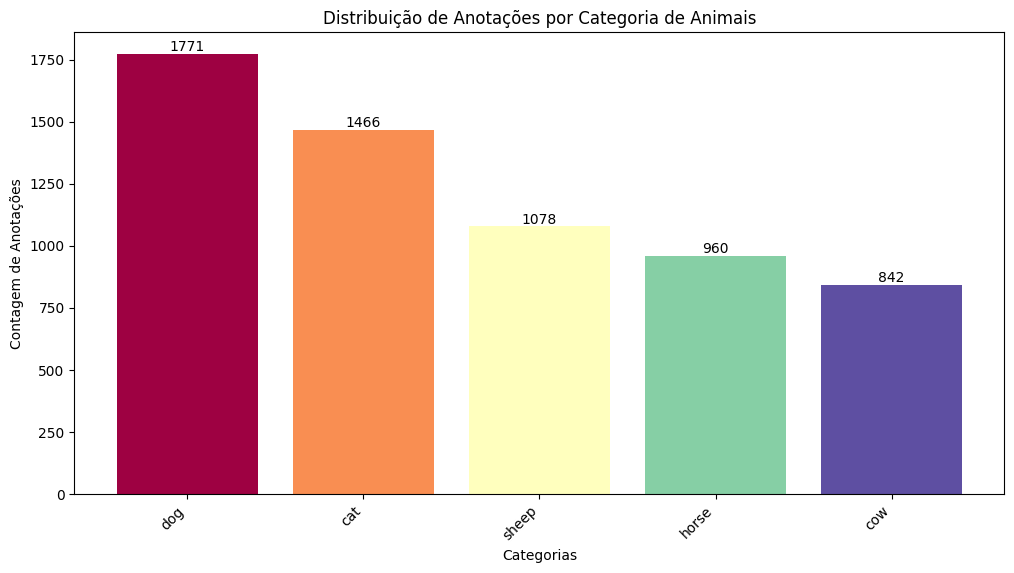

In [12]:
# Verificar a estrutura de 'categories' para retornar todas as categorias
categories_df = pd.DataFrame(data['categories']).set_index('id')

# Contar anotações por categoria
category_counts = annotations_df['category_id'].value_counts()

# Obter os nomes das categorias
category_names = categories_df.loc[category_counts.index]['name']

# Plotar o gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(category_names, category_counts, color=plt.cm.Spectral(np.linspace(0, 1, len(category_counts))))
plt.xticks(rotation=45, ha='right')
plt.title("Distribuição de Anotações por Categoria de Animais")
plt.xlabel("Categorias")
plt.ylabel("Contagem de Anotações")

# Adicionar rótulos de contagem
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

**Descrição:** Este gráfico mostra quantas anotações existem para cada categoria de animal, permitindo identificar quais grupos estão mais representados no dataset.

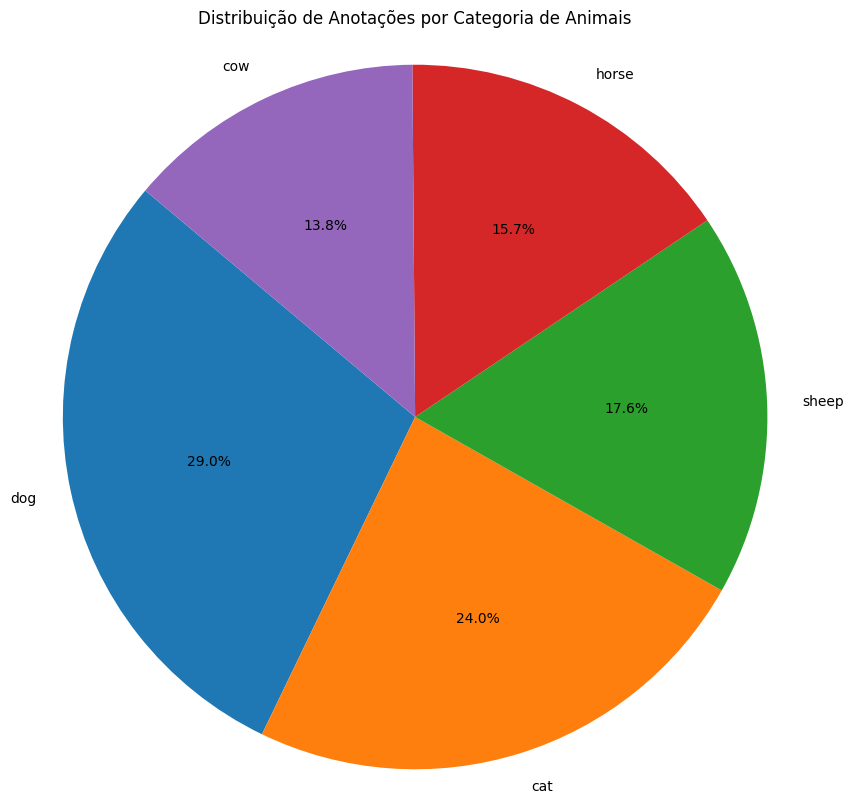

In [13]:
plt.figure(figsize=(10, 10))
plt.pie(category_counts, labels=category_names, autopct='%1.1f%%', startangle=140)
plt.title("Distribuição de Anotações por Categoria de Animais")
plt.axis('equal')
plt.show()

**Descrição:** Este gráfico ilustra a proporção das anotações de cada categoria no dataset, ajudando a visualizar quais categorias dominam.

In [14]:
# Filtrar anotações de bovinos (cows)
bovino_annotations = annotations_df[annotations_df['category_id'] == 5]

# Exibir a quantidade de anotações filtradas
print(f"Total de anotações de bovinos (cows): {len(bovino_annotations)}")

Total de anotações de bovinos (cows): 842


### Filtragem das imagens de bovinos

O dataset é filtrado para manter apenas as anotações e imagens relacionadas à categoria de bovinos (cows). Essa filtragem é necessária para realizar análises específicas e treinar o modelo apenas com bovinos.

In [15]:
# Converter o dicionário 'images' em uma lista de pares [id, imagem]
data = [[key, value] for key, value in data['images'].items()]

# Definir os nomes das colunas para o novo DataFrame
columns = ["id", "image"]

# Criar um DataFrame a partir dos dados
image_df = pd.DataFrame(data, columns=columns)

# Garantir que 'id' seja do tipo inteiro
image_df["id"] = image_df["id"].astype("int64")

# Merge image_df com bovino_annotations com base em 'id' e 'image_id'
merge_df = image_df.merge(bovino_annotations, how="inner", right_on='image_id', left_on='id')[[
    "id",
    "image",
    "keypoints",
    "bbox",
    "category_id"
]].set_index('id')

# Salvar o novo DataFrame como um arquivo JSON
merge_df.to_json('/content/drive/MyDrive/Animal Pose Estimation/merge_df.json', orient='records')
merge_df

,image,keypoints,bbox,category_id
id,,,,
5,2007_000464.jpg,"[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...","[71, 252, 216, 314]",5
5,2007_000464.jpg,"[[73, 225, 1], [0, 0, 0], [64, 240, 1], [84, 2...","[58, 202, 241, 295]",5
6,2007_000491.jpg,"[[0, 0, 0], [255, 46, 1], [308, 88, 1], [171, ...","[2, 2, 459, 334]",5
7,2007_000504.jpg,"[[363, 125, 1], [0, 0, 0], [343, 147, 1], [385...","[341, 102, 500, 406]",5
16,2007_000904.jpg,"[[248, 205, 1], [0, 0, 0], [238, 222, 1], [254...","[237, 167, 338, 263]",5
...,...,...,...,...
4004,co95.jpeg,"[[103, 68, 1], [83, 68, 1], [89, 91, 1], [110,...","[77, 48, 267, 206]",5
4005,co96.jpeg,"[[57, 75, 1], [0, 0, 0], [26, 118, 1], [85, 61...","[1, 9, 291, 275]",5
4006,co97.jpeg,"[[203, 37, 1], [0, 0, 0], [182, 64, 1], [235, ...","[43, 6, 243, 196]",5


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


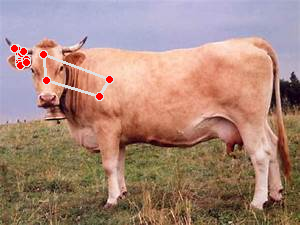

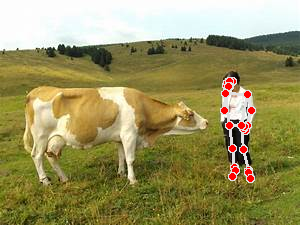

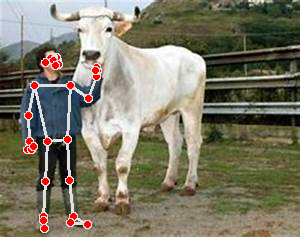

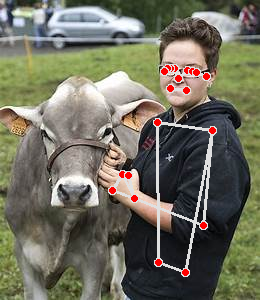

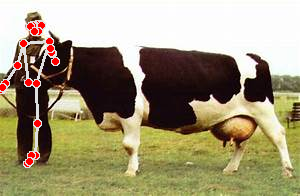

In [16]:
# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose

# Iterar sobre o DataFrame 'merge_df' para realizar pose estimation
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
    for index, row in merge_df.iterrows():
        image_path = f'/content/drive/MyDrive/Animal Pose Estimation/images/{row["image"]}'
        image = cv2.imread(image_path)

        if image is None:
            continue

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.pose_landmarks:
            continue

        # Desenhar e exibir a imagem
        annotated_image = image.copy()
        mp.solutions.drawing_utils.draw_landmarks(annotated_image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)
        cv2_imshow(annotated_image)